# Quarantine

Every morning every unquarantined infected that have been active for more than d days have a probability for getting caught and removed. Quarantining only starts after more than m people get infected

In [1]:
# Common variables

N = 1       # Number of simulations for a given set of conditions
P = 1000    # Number of people in each simulation
L = 10      # Size of the square box
r = 0.1     # Radius of infection
p = 0.2     # Probability of getting infected
T = 10      # Number of time steps in a day
D = 10      # Number of days the person stays infected
v = 0.5     # Drift velocity
d = int(D*0.4)    # The disease does not show for these many days
m = int(P*0.01)   # Quarantine starts after these many people get infected
pq = 0.8    # Probability that the infected showing symptoms will be quarantined
pc = 0.9    # Probability that the infected will be cured


# Status

S : Susceptible : Cyan

I : Infected : Orange

Q : Quarantined : Orange

C : Cured : Black

D : Dead : Black

R : Removed = Cured + Dead

Susceptible, Infected and Cured people keep moving.

In [2]:
import random
import math
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
class Person:
    
    # Contains all the information needed to track individually
    
    def __init__(self, pos):
        
        self.pos = pos
        self.status = 'S'
        self.proximity_to_infected = False
        self.days_infected = 0
        self.days_quarantined = 0


class Population:
    
    # Contains the population and the related functions
    
    def __init__(self, P, L, r, p, T, D, d, m, pq, pc):
        
        # Initialize the population at random locations
        
        self.P = P
        self.L = L
        self.r = r
        self.p = p
        self.T = T
        self.D = D
        self.d = d
        self.m = m
        self.pq = pq
        self.pc = pc
        self.Pop = [self.generate_person() for i in range(self.P)]
        self.n_S = self.P
        self.n_I = 0
        self.n_C = 0
        self.n_Q = 0
        self.n_D = 0

    def generate_person(self):
        
        # Initialize each person at a random location
        
        pos = [random.random()*self.L, random.random()*self.L]
        return Person(pos)
    
    
    def place_in_quarantine(self,i):
        
        # Quarantining in a nearby area
        
        l1 = self.L*0.1
        l2 = self.L*0.1
        pos = [-random.random()*l1-l2, random.random()*l1]
        self.Pop[i].pos = pos
        
        
    def place_in_morgue(self,i):
        
        # Dead people are placed in a morgue
        
        l1 = self.L*0.1
        l2 = self.L*0.1
        pos = [-random.random()*l1-l2, self.L-random.random()*l1]
        self.Pop[i].pos = pos
        
    
    
    def show_pos(self):
        
        # Displays the position of each person and the their status using colors
        
        clear_output(wait = True)
        plt.figure(figsize=(8,8))
        
        for S,color in zip('SIQCD', ['cyan', 'orange', 'orange', 'black', 'blue']):

            pos_x = [-1]*self.P
            pos_y = [-1]*self.P

            for i in range(self.P):

                if self.Pop[i].status == S:
                    
                    pos_x[i], pos_y[i] = self.Pop[i].pos[0], self.Pop[i].pos[1] 
                    
            pos_x = [i for i in pos_x if i != -1]
            pos_y = [i for i in pos_y if i != -1]

            plt.scatter(pos_x, pos_y, s = 6, c = color)
            
        plt.xlim([-0.3*self.L, 1.1*self.L])     
        plt.plot([-0.1, self.L+0.1, self.L+0.1, -0.1, -0.1], [-0.1, -0.1, self.L+0.1, self.L+0.1, -0.1])
        l1 = self.L*0.1
        plt.plot([-0.1-2*l1, 0.1-l1, 0.1-l1, -0.1-2*l1, -0.1-2*l1], [-0.1, -0.1, l1+0.1, l1+0.1, -0.1])
        plt.plot([-0.1-2*l1, 0.1-l1, 0.1-l1, -0.1-2*l1, -0.1-2*l1], 
                 [self.L-0.1-l1, self.L-0.1-l1, self.L+0.1, self.L+0.1, self.L-0.1-l1])
        plt.show()
        
    
    def start_infection(self, n):
        
        # Starts the infection with n people
        
        for i in range(n):
            
            self.Pop[i].status = 'I'
            self.n_S -= 1
            self.n_I += 1
            self.Pop[i].days_infected = 1
        
    def move_person(self, i, v):
        
        # Moves a person in each time step of the day in a random direction
        # Ensures that the person stays inside the boundary
        
        if self.Pop[i].status in 'SIC':
    
            theta = random.random()*math.pi*2 
            current_pos = self.Pop[i].pos
            self.Pop[i].pos = [current_pos[0] + v*math.cos(theta), current_pos[1] + v*math.sin(theta)]
            if self.Pop[i].pos[0] < 0:
                self.Pop[i].pos[0] = 0
            elif self.Pop[i].pos[0] > self.L:
                self.Pop[i].pos[0] = self.L

            if self.Pop[i].pos[1] < 0:
                self.Pop[i].pos[1] = 0
            elif self.Pop[i].pos[1] > self.L:
                self.Pop[i].pos[1] = self.L
        
        
            
    def infection_distance(self):
        
        # Checks if any person has come into the infection range of an infected person
        
        infected_pos = []
        
        for i in range(self.P):
            
            if self.Pop[i].status == 'I':
                
                infected_pos.append(self.Pop[i].pos)
                
        for i in range(self.P):
            
            if self.Pop[i].status != 'S':
                
                continue
                
            if self.Pop[i].proximity_to_infected:
                
                continue
            
            x,y = self.Pop[i].pos[0], self.Pop[i].pos[1]
            
            for i_pos in infected_pos:
                
                dis = math.sqrt((i_pos[0] - x)**2 + (i_pos[1] - y)**2)
                
                if dis < self.r:
                    
                    self.Pop[i].proximity_to_infected = True        
    
    
    def Simulate_day(self, v):
        
        # Running the simulation for a day
        
        for _ in range(self.T):
            
            for i in range(self.P):
                
                self.move_person(i, v)
            
            self.infection_distance()
    
    
    def set_infections(self):
        
        # Changes the infection status at the end of the day
        
        for i in range(self.P):
            
            if self.Pop[i].status == 'S' and self.Pop[i].proximity_to_infected:
                
                if random.random() <= self.p:
                    
                    self.Pop[i].status = 'I'
                    self.Pop[i].proximity_to_infected = 1
                    self.n_I += 1
                    self.n_S -= 1
                
                else:
                    
                    self.Pop[i].proximity_to_infected = False
                
            elif self.Pop[i].status == 'I':
                
                if self.Pop[i].days_infected <= self.D:
                    
                    self.Pop[i].days_infected += 1
                
                elif random.random() <= pc:
                    
                    self.Pop[i].status = 'C'
                    self.n_I -= 1
                    self.n_C += 1
                    
                else:
                    
                    self.Pop[i].status = 'D'
                    self.n_I -= 1
                    self.n_D += 1
                    self.place_in_morgue(i)
                    
    
    def Quarantine(self):
        
        # Quarantines those infected that shows symptoms. Places the cured ones back
        # Since it is known that the symptoms start after d days, quarantine is only for D-d days
        
        for i in range(self.P):
            
            if self.Pop[i].status == 'I' and self.Pop[i].days_infected > self.d and random.random() < self.pq:
                
                self.Pop[i].status = 'Q'
                self.Pop[i].days_quarantined = 1
                self.n_Q += 1
                self.n_I -= 1
                self.place_in_quarantine(i)
                
            elif self.Pop[i].status == 'Q':
                
                if self.Pop[i].days_quarantined <= self.D-self.d:
                    
                    self.Pop[i].days_quarantined += 1
                    
                elif random.random() <= pc:
                    
                    self.Pop[i].status = 'C'
                    self.Pop[i].days_infected = 0
                    self.n_Q -= 1
                    self.n_C += 1
                    self.Pop[i].pos = [random.random()*self.L, random.random()*self.L]
                    
                else:
                    
                    self.Pop[i].status = 'D'
                    self.Pop[i].days_infected = 0
                    self.n_Q -= 1
                    self.n_D += 1
                    self.place_in_morgue(i)
                    
    
    
    def quarantine_exp_show(self, v):
        
        # Performs the quarantine experiment and shows the progression of the spread
        
        sus = []
        inf = []
        qua = []
        rem = []
        q_started = False
        
        while self.n_I or self.n_Q:
            
            if q_started:
                self.Quarantine()
            self.Simulate_day(v)
            self.set_infections()
            if self.n_I > self.m:
                q_started = True
            time.sleep(0.001)
            self.show_pos()
            sus.append(self.n_S)
            inf.append(self.n_I)
            qua.append(self.n_Q)
            rem.append(self.n_C + self.n_D)
            
        
        return sus, inf, qua, rem
            
            
    def quarantine_exp(self, v):
        
        # Performs the quarantine experiment without showing the progression of the spread
        
        sus = []
        inf = []
        qua = []
        rem = []
        q_started = False
        
        while self.n_I or self.n_Q:
            
            if q_started:
                self.Quarantine()
            self.Simulate_day(v)
            self.set_infections()
            if self.n_I > self.m:
                q_started = True
            sus.append(self.n_S)
            inf.append(self.n_I)
            qua.append(self.n_Q)
            rem.append(self.n_C + self.n_D)
        
        plt.plot(sus)
        plt.plot(inf)
        plt.plot(rem)
        plt.plot(qua)
        plt.legend(['S', 'I', 'R', 'Q'])
        
        return sus, inf, qua, rem
            


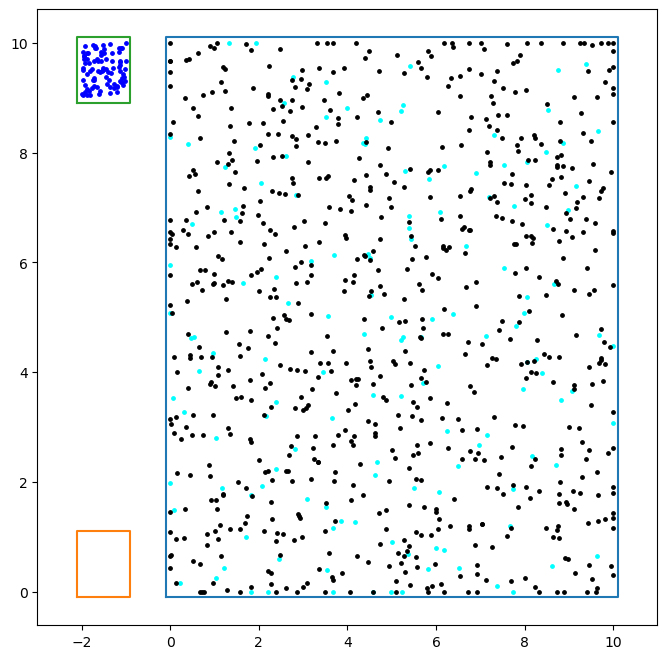

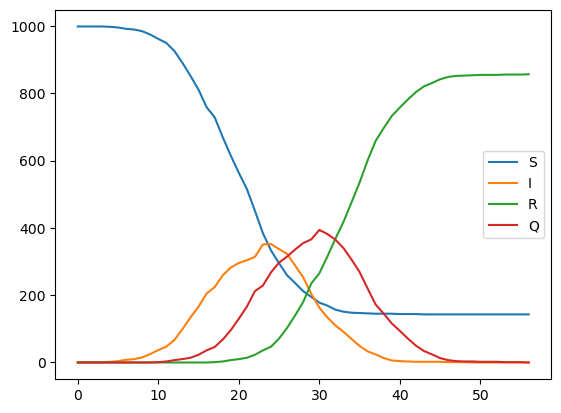

In [4]:
G = Population(P, L, r, p, T, D, d, m, pq, pc)
G.start_infection(1)
G.show_pos()
sus, inf, qua, rem = G.quarantine_exp_show(v)

plt.figure()
plt.plot(sus)
plt.plot(inf)
plt.plot(rem)
plt.plot(qua)
plt.legend(['S', 'I', 'R', 'Q'])
plt.show()

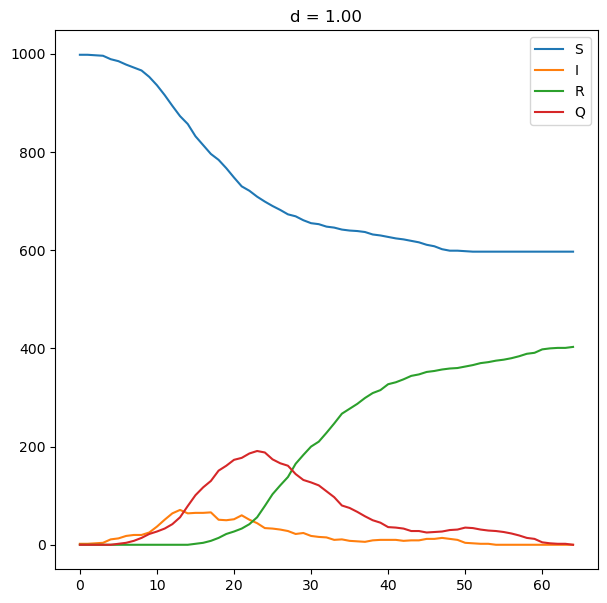

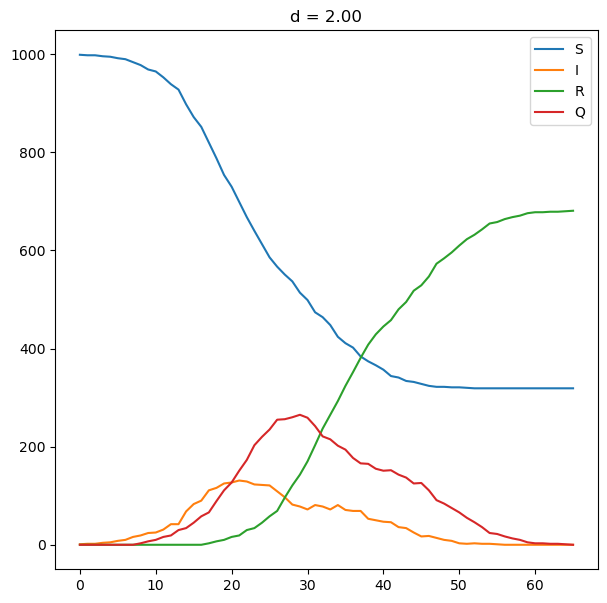

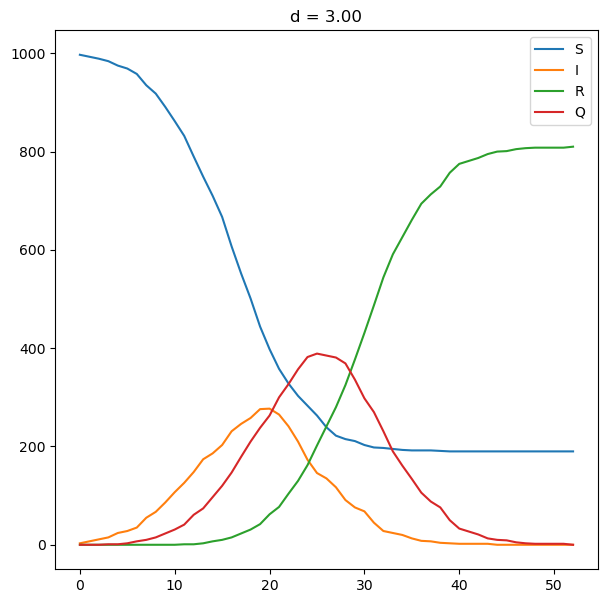

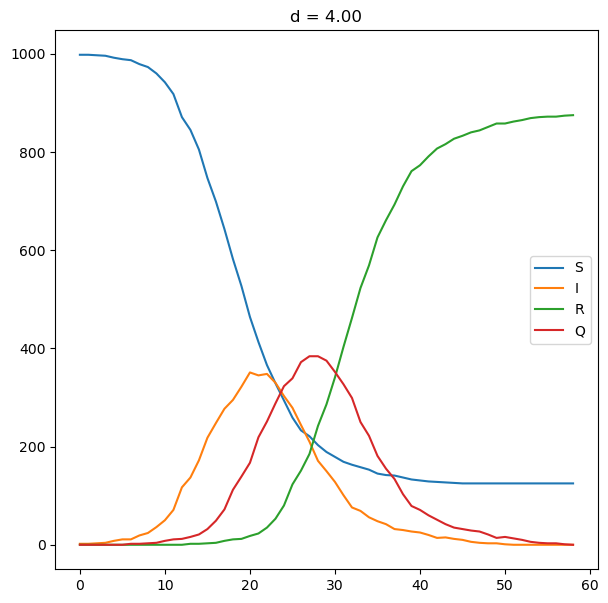

In [5]:
# Quarantine variables : effect of d

for d in [1, 2, 3, 4]:

    plt.figure(figsize = (7,7))
    G = Population(P, L, r, p, T, D, d, m, pq, pc)
    G.start_infection(1)
    sus, inf, qua, rem = G.quarantine_exp(v)
    plt.title('d = %1.2f' %d)
    plt.show()